In [ ]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.1 MB/s eta 0:00:00


In [ ]:
!pip uninstall mtcnn

Found existing installation: mtcnn 1.0.0
Uninstalling mtcnn-1.0.0:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/mtcnn-1.0.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/mtcnn/*
Proceed (Y/n)? Y
  Successfully uninstalled mtcnn-1.0.0


In [ ]:
!pip install mtcnn

  Using cached mtcnn-1.0.0-py3-none-any.whl.metadata (5.8 kB)
Using cached mtcnn-1.0.0-py3-none-any.whl (1.9 MB)


In [ ]:
# now the session will restart and we will continue executing from below

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, Flatten

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from google.colab import drive
import cv2
import numpy as np


In [ ]:

# Step 2: Mount Google Drive
drive.mount('/content/drive')

# Step 3: Define dataset path
dataset_path = "/content/drive/MyDrive/Capstone/Friends_Dataset_New_BW_61"

Mounted at /content/drive


In [ ]:


# Use the custom generator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.1,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=64,
    class_mode="sparse", #"categorical",
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=64,
    class_mode="sparse", #"categorical",
    subset="validation"
)


Found 665 images belonging to 12 classes.
Found 72 images belonging to 12 classes.


In [ ]:
# Step 5: Define Spiking Coding Layer
class SpikingCodingLayer(Layer):
    def __init__(self, threshold=0.5, **kwargs):
        super(SpikingCodingLayer, self).__init__(**kwargs)
        self.threshold = threshold

    def call(self, inputs):
        # Mimic spiking behavior: binary activation based on threshold
        return tf.cast(inputs > self.threshold, tf.float32)


In [ ]:
# Step 6: Define Liquid Layer (Core)
class LiquidLayer(Layer):
    def __init__(self, units, time_constant=0.2, step_size=0.02, **kwargs):
        super(LiquidLayer, self).__init__(**kwargs)
        self.units = units
        self.time_constant = time_constant
        self.step_size = step_size

    def build(self, input_shape):
        self.w_in = self.add_weight(shape=(input_shape[-1], self.units),
                                    initializer="random_normal",
                                    trainable=True)
        self.w_rec = self.add_weight(shape=(self.units, self.units),
                                     initializer="random_normal",
                                     trainable=True)
        self.bias = self.add_weight(shape=(self.units,),
                                    initializer="zeros",
                                    trainable=True)

    def call(self, inputs, states=None):
        if states is None:
            states = tf.zeros((tf.shape(inputs)[0], self.units))

        for t in range(10):  # Unrolling for fixed steps
            dx_dt = tf.nn.tanh(tf.matmul(inputs, self.w_in) +
                               tf.matmul(states, self.w_rec) + self.bias)
            states += self.step_size * dx_dt / (1 + self.step_size / self.time_constant + dx_dt)

        return states

In [ ]:

# Step 7: Build the LNN Model with additional regularization
inputs = Input(shape=(64, 64, 3))
x = tf.keras.layers.Flatten()(inputs)  # Flatten the spatial dimensions and color channels

x = SpikingCodingLayer()(x)
x = LiquidLayer(128)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs, outputs)


In [ ]:
# Step 8: Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Step 9: Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=500
)

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 198s 6s/step - accuracy: 0.0888 - loss: 2.5343 - val_accuracy: 0.1806 - val_loss: 2.2870
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 341ms/step - accuracy: 0.1743 - loss: 2.3148 - val_accuracy: 0.2500 - val_loss: 2.1653
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.2471 - loss: 2.1507 - val_accuracy: 0.2361 - val_loss: 2.1690
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 320ms/step - accuracy: 0.2417 - loss: 2.1976 - val_accuracy: 0.3472 - val_loss: 2.0889
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - accuracy: 0.2730 - loss: 2.1395 - val_accuracy: 0.3333 - val_loss: 2.0511
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step - accuracy: 0.3131 - loss: 2.0731 - val_accuracy: 0.3056 - val_loss: 2.1036
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.2969 - loss: 2.0701 - val_accuracy: 0.3194 - val_loss: 2.0125
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.2952 - loss: 2.0551 - val_accuracy: 0.30

In [ ]:

# Print train and validation accuracy
train_accuracy = history.history['accuracy'][-1]  # Last epoch train accuracy
validation_accuracy = history.history['val_accuracy'][-1]  # Last epoch validation accuracy

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {validation_accuracy:.4f}")




Final Training Accuracy: 0.8241
Final Validation Accuracy: 0.7639


In [ ]:
# Step 11: Save the model
model_save_path = "/content/drive/MyDrive/Capstone/Models/New/Capstone_lnn_class_picsBW61_mtcnn_ep500.h5"
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/Capstone/Models/New/Capstone_lnn_class_picsBW61_mtcnn_ep500.h5


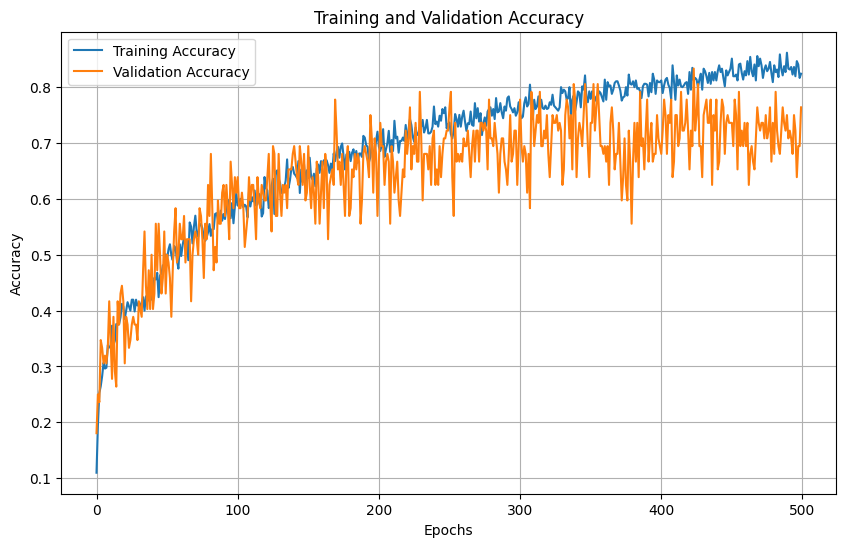

In [ ]:
import matplotlib.pyplot as plt

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


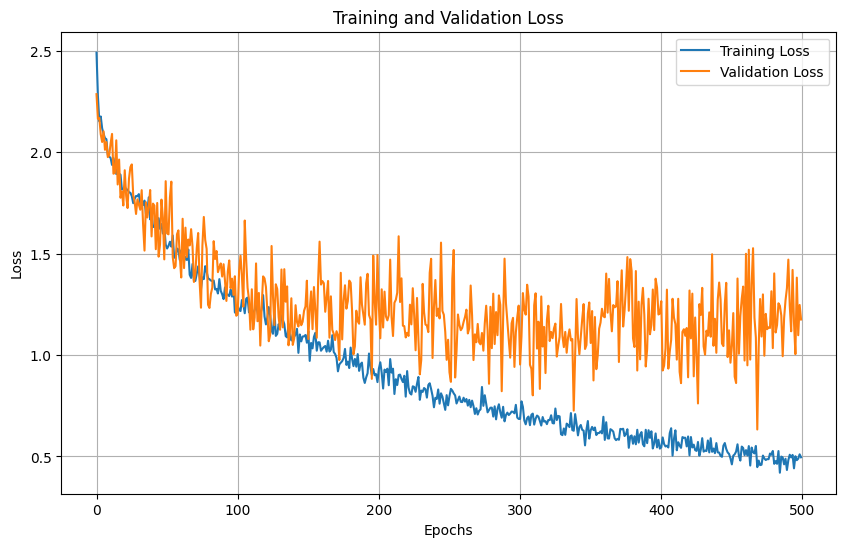

In [ ]:

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()



3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


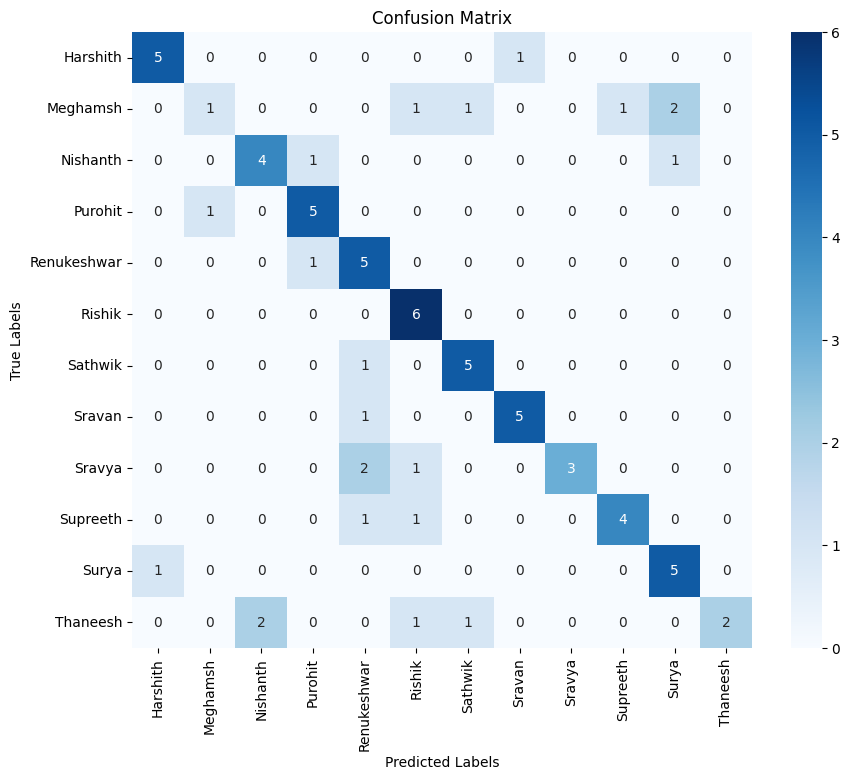

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get validation data
val_x, val_y = [], []
for i in range(len(validation_generator)):
    batch_x, batch_y = validation_generator[i]
    val_x.extend(batch_x)
    val_y.extend(batch_y)
val_x = np.array(val_x)
val_y = np.array(val_y)

# Make predictions
predictions = model.predict(val_x)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(val_y, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
'''
from sklearn.metrics import precision_score, recall_score, f1_score

# Custom callback to compute metrics
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        self.val_data = val_data
        self.precision = []
        self.recall = []
        self.f1 = []

    def on_epoch_end(self, epoch, logs=None):
        val_x, val_y = self._get_validation_data()
        predictions = self.model.predict(val_x)
        predicted_classes = np.argmax(predictions, axis=1)

        precision = precision_score(val_y, predicted_classes, average='weighted')
        recall = recall_score(val_y, predicted_classes, average='weighted')
        f1 = f1_score(val_y, predicted_classes, average='weighted')

        self.precision.append(precision)
        self.recall.append(recall)
        self.f1.append(f1)

    def _get_validation_data(self):
        val_x, val_y = [], []
        for i in range(len(self.val_data)):
            batch_x, batch_y = self.val_data[i]
            val_x.extend(batch_x)
            val_y.extend(batch_y)
        return np.array(val_x), np.array(val_y)

# Instantiate and use the callback
metrics_callback = MetricsCallback(validation_generator)

# Train model again (use if necessary for metric computation)
# history = model.fit(train_generator, validation_data=validation_generator, epochs=200, callbacks=[metrics_callback])

# Plot metrics over epochs
plt.figure(figsize=(10, 6))
plt.plot(metrics_callback.precision, label='Precision')
plt.plot(metrics_callback.recall, label='Recall')
plt.plot(metrics_callback.f1, label='F1 Score')
plt.title('Precision, Recall, and F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()
'''

"\nfrom sklearn.metrics import precision_score, recall_score, f1_score\n\n# Custom callback to compute metrics\nclass MetricsCallback(tf.keras.callbacks.Callback):\n    def __init__(self, val_data):\n        self.val_data = val_data\n        self.precision = []\n        self.recall = []\n        self.f1 = []\n\n    def on_epoch_end(self, epoch, logs=None):\n        val_x, val_y = self._get_validation_data()\n        predictions = self.model.predict(val_x)\n        predicted_classes = np.argmax(predictions, axis=1)\n\n        precision = precision_score(val_y, predicted_classes, average='weighted')\n        recall = recall_score(val_y, predicted_classes, average='weighted')\n        f1 = f1_score(val_y, predicted_classes, average='weighted')\n\n        self.precision.append(precision)\n        self.recall.append(recall)\n        self.f1.append(f1)\n\n    def _get_validation_data(self):\n        val_x, val_y = [], []\n        for i in range(len(self.val_data)):\n            batch_x, batc

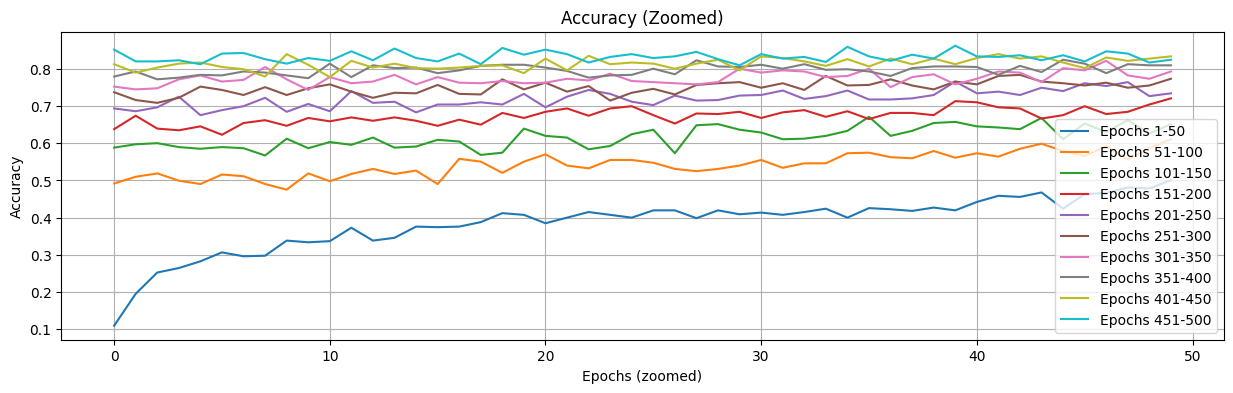

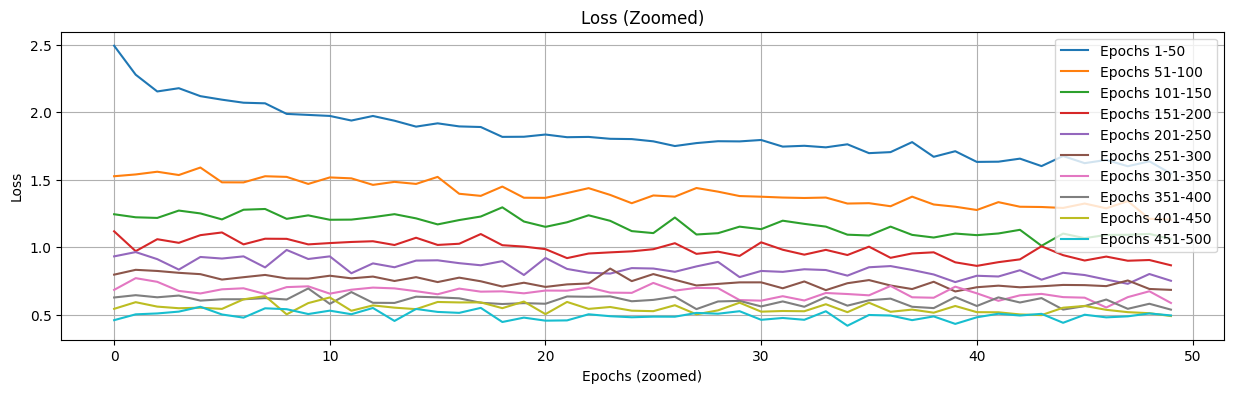

In [ ]:
# 4. Epoch-wise Zoomed View of Accuracy and Loss
for metric, label in zip(['accuracy', 'loss'], ['Accuracy', 'Loss']):
    plt.figure(figsize=(15, 4))
    for epoch in range(0, len(history.history[metric]), 50):  # Zoomed every 50 epochs
        plt.plot(history.history[metric][epoch:epoch+50], label=f'Epochs {epoch+1}-{epoch+50}')
    plt.title(f'{label} (Zoomed)')
    plt.xlabel('Epochs (zoomed)')
    plt.ylabel(label)
    plt.legend()
    plt.grid()
    plt.show()

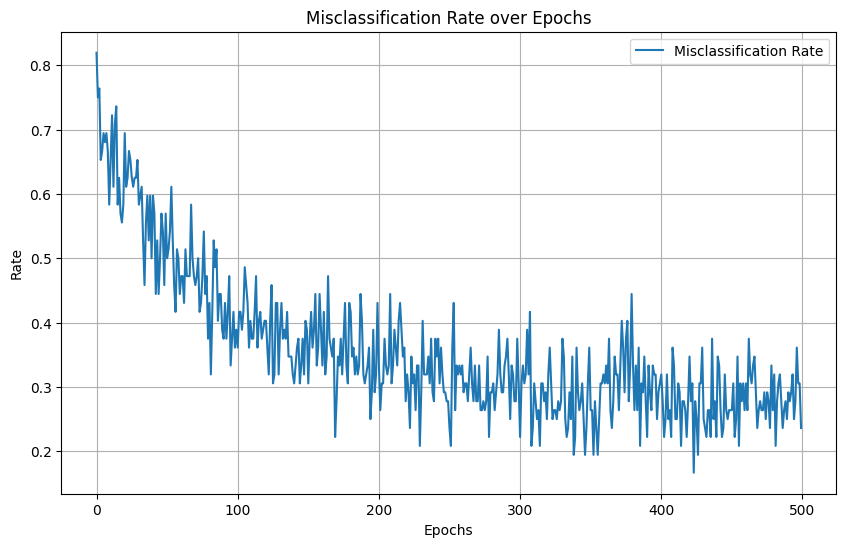

In [ ]:
#Epoch-Wise Misclassification Distribution
# Compute misclassification rate
misclassification_rate = [
    1 - acc for acc in history.history['val_accuracy']
]

# Plot misclassification rate
plt.figure(figsize=(10, 6))
plt.plot(misclassification_rate, label='Misclassification Rate')
plt.title('Misclassification Rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.legend()
plt.grid()
plt.show()


In [ ]:
#Ensure Data Compatibility

# Get validation data
val_x, val_y = [], []
for i in range(len(validation_generator)):
    batch_x, batch_y = validation_generator[i]
    val_x.extend(batch_x)
    val_y.extend(batch_y)
    if len(val_x) >= validation_generator.samples:  # Stop when all samples are loaded
        break
val_x = np.array(val_x)
val_y = np.array(val_y)



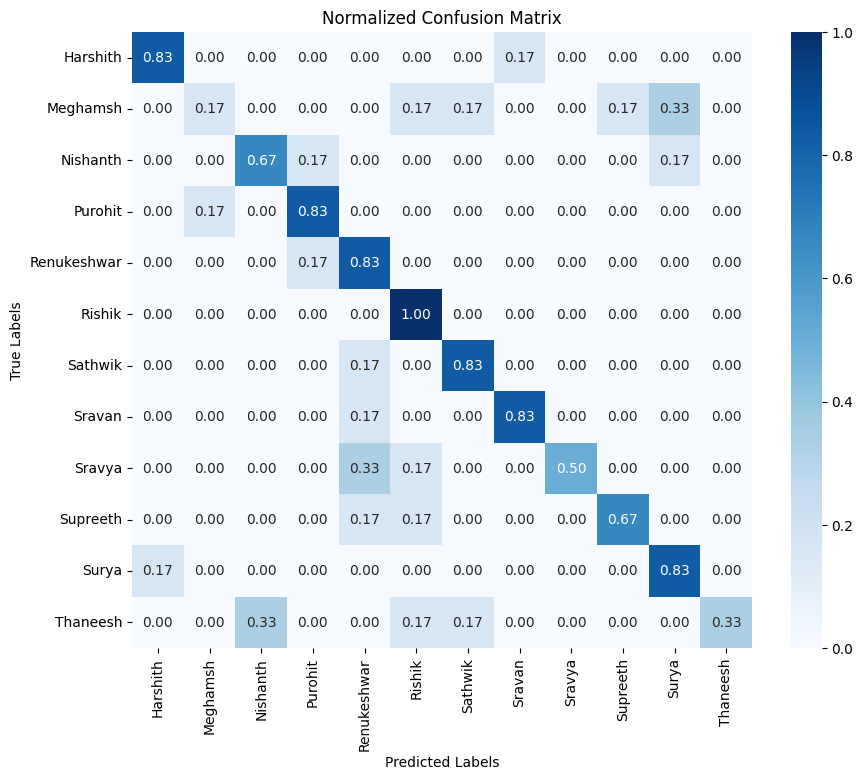

In [ ]:
# Confusion Matrix Improvements
# Add percentage values to confusion matrix annotations for clarity:
# Compute confusion matrix
conf_matrix = confusion_matrix(val_y, predicted_classes)

# Normalize confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


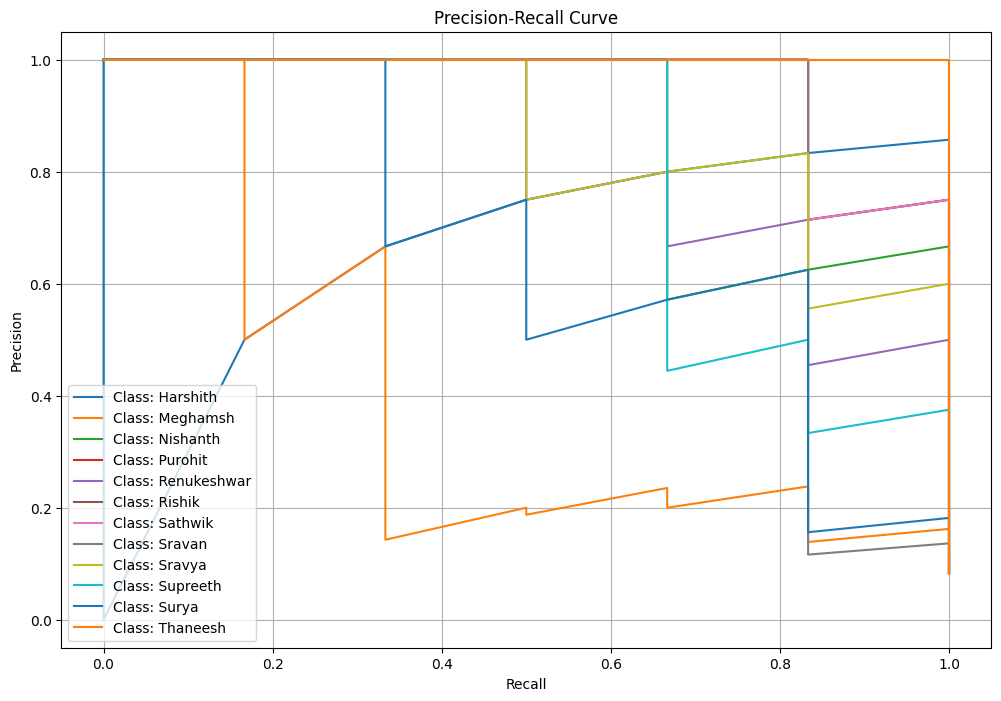

In [ ]:
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve for each class
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(train_generator.class_indices.keys()):
    precision, recall, _ = precision_recall_curve((val_y == i).astype(int), predictions[:, i])
    plt.plot(recall, precision, label=f'Class: {class_name}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()


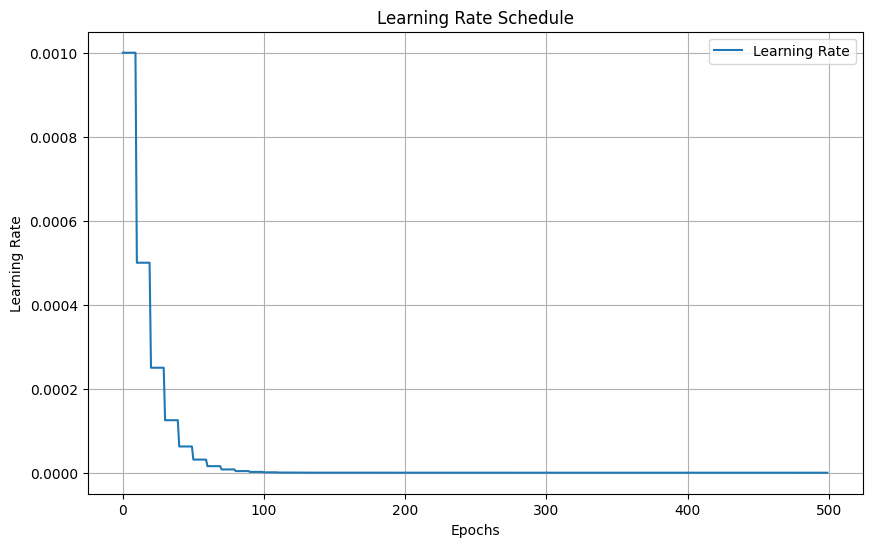

In [ ]:
#Learning Rate Scheduler Visualization
# Example: Assuming you use a learning rate scheduler
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10
    return initial_lr * (drop ** (epoch // epochs_drop))

learning_rates = [lr_schedule(epoch) for epoch in range(len(history.history['loss']))]

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid()
plt.show()


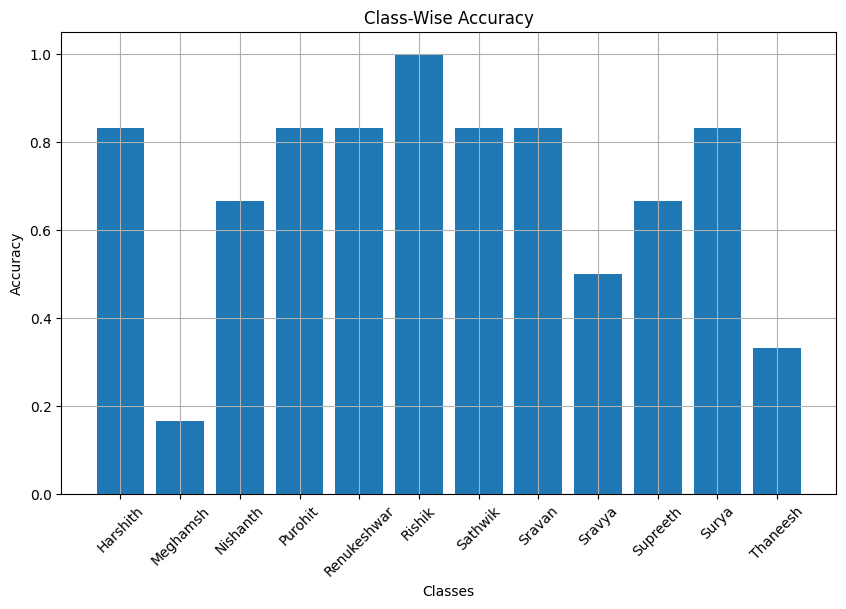

In [ ]:
#Class-Wise Accuracy

class_accuracies = {}
for class_name, class_index in train_generator.class_indices.items():
    class_mask = (val_y == class_index)
    correct_predictions = (predicted_classes[class_mask] == val_y[class_mask]).sum()
    class_accuracy = correct_predictions / class_mask.sum()
    class_accuracies[class_name] = class_accuracy

# Plot class-wise accuracies
plt.figure(figsize=(10, 6))
plt.bar(class_accuracies.keys(), class_accuracies.values())
plt.title('Class-Wise Accuracy')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid()
plt.show()


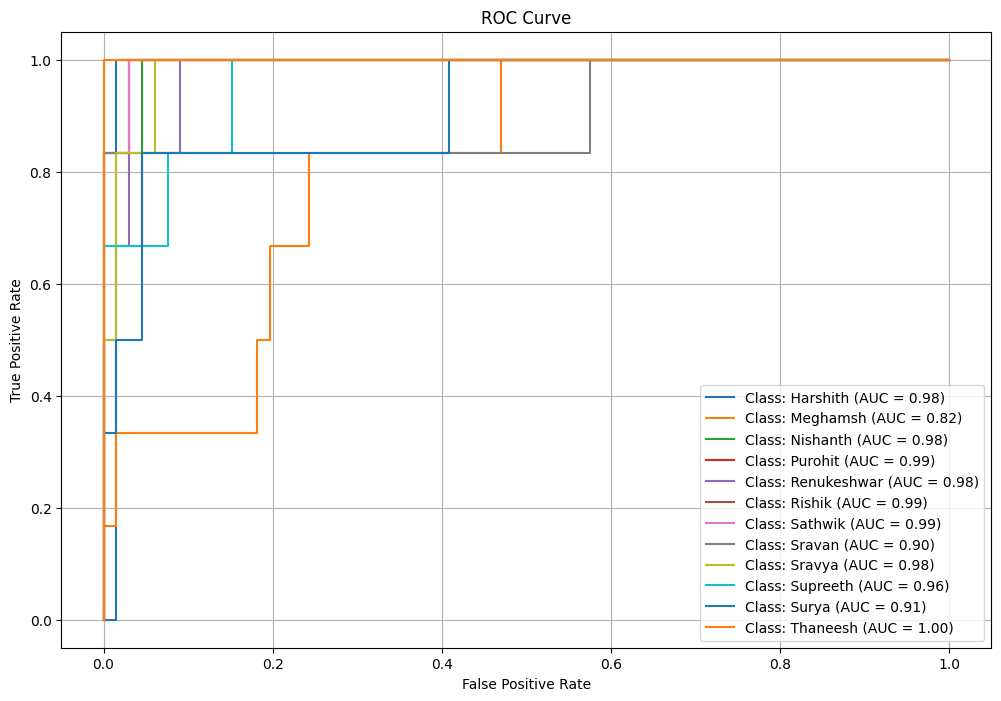

In [ ]:
#Add ROC Curves
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 8))
for i, class_name in enumerate(train_generator.class_indices.keys()):
    fpr, tpr, _ = roc_curve((val_y == i).astype(int), predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class: {class_name} (AUC = {roc_auc:.2f})')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Step 11: Load and preprocess a single image
def load_and_preprocess_image(image_path, target_size=(64, 64)):
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    plt.imshow(img)  # Display the image
    plt.axis("off")
    plt.show()

    img_array = img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Step 12: Make predictions
def predict_image(image_path, model, class_indices):
    img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]

    # Map index to class name
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class_name = class_labels[predicted_class_index]

    return predicted_class_name

# Step 13: Randomly select an image and test the model
def test_random_image(dataset_path, model, class_indices):
    # Select a random image from the dataset
    all_classes = os.listdir(dataset_path)
    selected_class = random.choice(all_classes)
    selected_class_path = os.path.join(dataset_path, selected_class)
    all_images = os.listdir(selected_class_path)
    selected_image = random.choice(all_images)
    selected_image_path = os.path.join(selected_class_path, selected_image)

    # Print actual class
    print(f"Actual Class: {selected_class}")

    # Predict the class using the model
    predicted_class_name = predict_image(selected_image_path, model, class_indices)

    # Print predicted class
    print(f"Predicted Class: {predicted_class_name}")



Actual Class: Nishanth


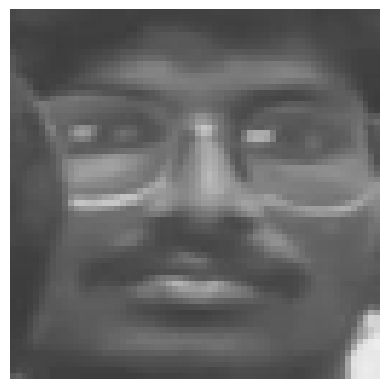

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Class: Nishanth


In [ ]:

# Path to the dataset (test or train for random image selection)
dataset_path = "/content/drive/MyDrive/Capstone/Friends_Dataset_New_BW_61"

# Test the model with a random image
test_random_image(dataset_path, model, train_generator.class_indices)

Actual Class: Rishik


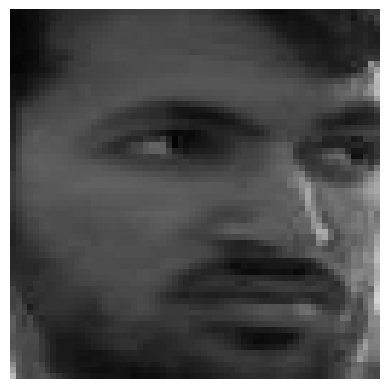

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Class: Rishik


In [ ]:

# Test the model with a random image
test_random_image(dataset_path, model, train_generator.class_indices)

Actual Class: Sathwik


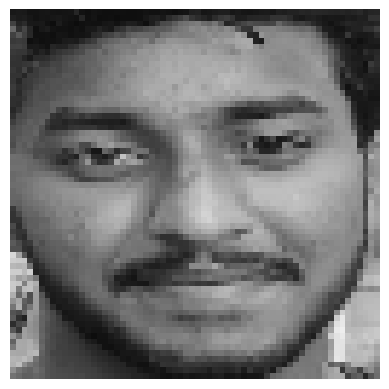

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Class: Sathwik


In [ ]:

# Test the model with a random image
test_random_image(dataset_path, model, train_generator.class_indices)

Actual Class: Thaneesh


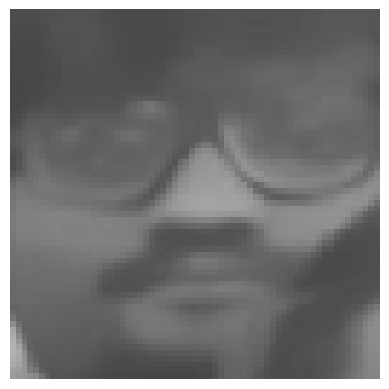

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Class: Thaneesh


In [ ]:

# Test the model with a random image
test_random_image(dataset_path, model, train_generator.class_indices)

Actual Class: Surya


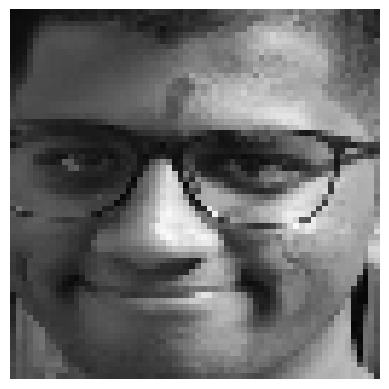

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Class: Surya


In [ ]:

# Test the model with a random image
test_random_image(dataset_path, model, train_generator.class_indices)

Actual Class: Purohit


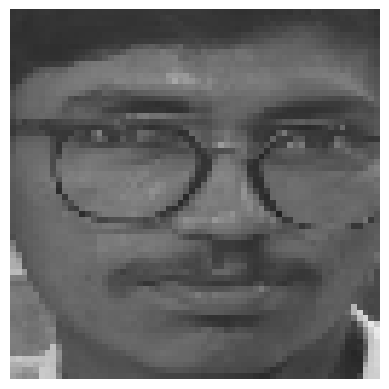

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Class: Purohit


In [ ]:

# Test the model with a random image
test_random_image(dataset_path, model, train_generator.class_indices)

Actual Class: Harshith


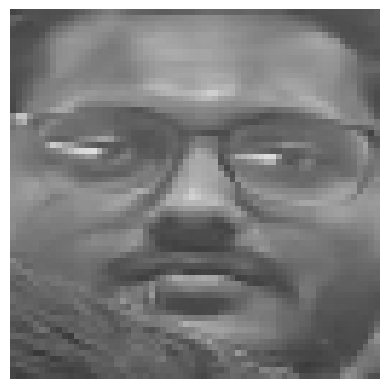

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Class: Harshith


In [ ]:

# Test the model with a random image
test_random_image(dataset_path, model, train_generator.class_indices)

Actual Class: Sravan


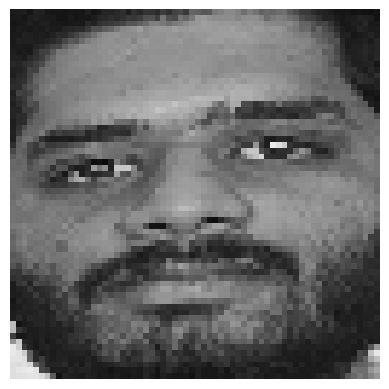

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Class: Sravan


In [ ]:

# Test the model with a random image
test_random_image(dataset_path, model, train_generator.class_indices)

Actual Class: Sravya


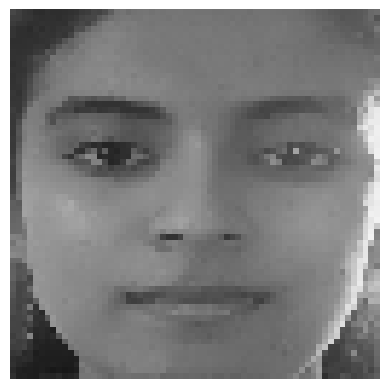

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Class: Sravya


In [ ]:

# Test the model with a random image
test_random_image(dataset_path, model, train_generator.class_indices)

Actual Class: Harshith


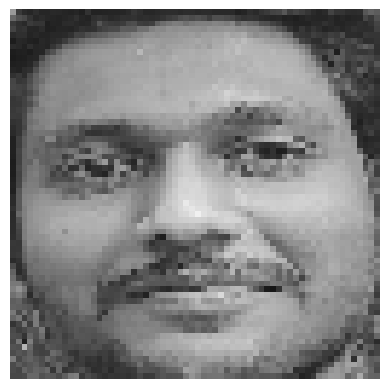

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Class: Harshith


In [ ]:

# Test the model with a random image
test_random_image(dataset_path, model, train_generator.class_indices)

Actual Class: Sravan


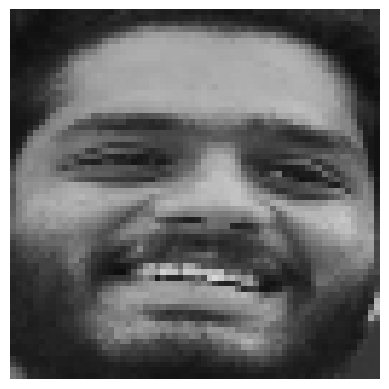

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Class: Sravan


In [ ]:

# Test the model with a random image
test_random_image(dataset_path, model, train_generator.class_indices)

Actual Class: Sravya


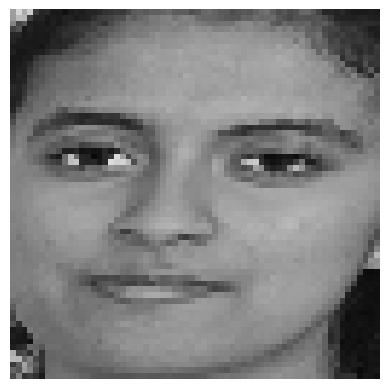

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Class: Sravya


In [ ]:

# Test the model with a random image
test_random_image(dataset_path, model, train_generator.class_indices)

Actual Class: Renukeshwar


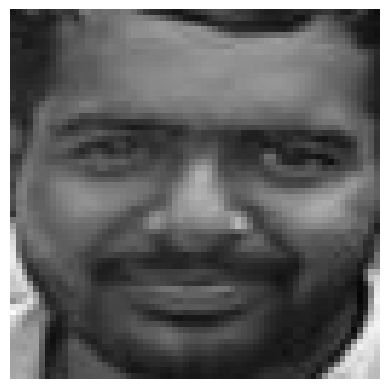

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Class: Renukeshwar


In [ ]:

# Test the model with a random image
test_random_image(dataset_path, model, train_generator.class_indices)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Step 11: Load and preprocess a single image
def load_and_preprocess_image(image_path, target_size=(64, 64)):
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    plt.imshow(img)  # Display the image
    plt.axis("off")
    plt.show()

    img_array = img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Step 12: Make predictions
def predict_image(image_path, model, class_indices):
    img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]

    # Map index to class name
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class_name = class_labels[predicted_class_index]

    return predicted_class_name

# Step 13: Test the model with a specific image
def test_specific_image(image_path, model, class_indices):
    # Extract actual class from the image path
    actual_class = os.path.basename(os.path.dirname(image_path))

    # Print actual class
    print(f"Actual Class: {actual_class}")

    # Predict the class using the model
    predicted_class_name = predict_image(image_path, model, class_indices)

    # Print predicted class
    print(f"Predicted Class: {predicted_class_name}")



Actual Class: Harshith


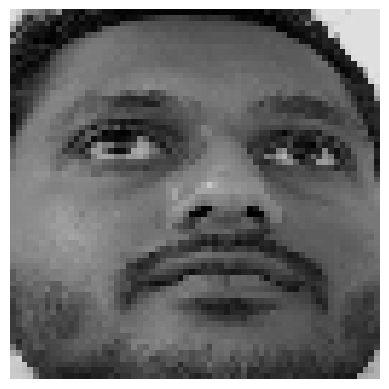

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Class: Harshith


In [ ]:
# Path to the specific image
specific_image_path = "/content/drive/MyDrive/Capstone/Friends_Dataset_New_BW_61/Harshith/IMG-20241224-WA0086_face1.jpg"

# Test the model with the specific image
test_specific_image(specific_image_path, model, train_generator.class_indices)


Actual Class: Purohit


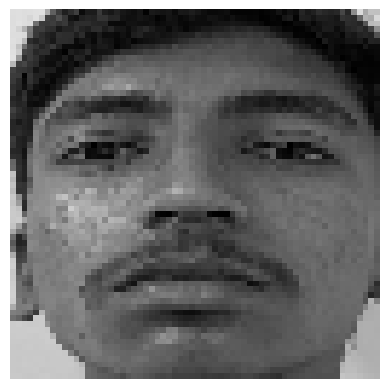

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Class: Purohit


In [ ]:
# Path to the specific image
specific_image_path = "/content/drive/MyDrive/Capstone/Friends_Dataset_New_BW_61/Purohit/IMG-20241224-WA0141_face1.jpg"

# Test the model with the specific image
test_specific_image(specific_image_path, model, train_generator.class_indices)


In [ ]:
#!pip install mtcnn

In [ ]:
'''
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects

# Register your custom layers with Keras
get_custom_objects().update({
    'SpikingCodingLayer': SpikingCodingLayer,
    'LiquidLayer': LiquidLayer
})

# Step 1: Load the pre-trained model from the .h5 file
model_path = '/content/drive/MyDrive/Capstone/Models/Capstone_lnn_class_picsBW50_mtcnn_ep50_all_optimized.h5'
model = load_model(model_path)

# Step 2: Check model architecture
model.summary()  # This will print out the architecture of the loaded model
'''

"\nimport tensorflow as tf\nfrom tensorflow.keras.models import load_model\nfrom tensorflow.keras.utils import get_custom_objects\n\n# Register your custom layers with Keras\nget_custom_objects().update({\n    'SpikingCodingLayer': SpikingCodingLayer,\n    'LiquidLayer': LiquidLayer\n})\n\n# Step 1: Load the pre-trained model from the .h5 file\nmodel_path = '/content/drive/MyDrive/Capstone/Models/Capstone_lnn_class_picsBW50_mtcnn_ep50_all_optimized.h5'\nmodel = load_model(model_path)\n\n# Step 2: Check model architecture\nmodel.summary()  # This will print out the architecture of the loaded model\n"

In [ ]:
import cv2
import numpy as np
from mtcnn import MTCNN  # Install with `pip install mtcnn`
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# Step 1: Face Detection
def detect_faces(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for MTCNN
    detector = MTCNN()  # Initialize the MTCNN detector

    # Detect faces
    detections = detector.detect_faces(image_rgb)

    return image, image_rgb, detections

# Step 2: Crop and Recognize Faces
# Modified function to display individual photos in a grid
def crop_and_recognize_faces(image_rgb, detections, model, class_indices):
    class_labels = {v: k for k, v in class_indices.items()}

    faces_with_predictions = []  # Store faces and predictions for later display

    for i, detection in enumerate(detections):
        '''
        x, y, width, height = detection['box']
        x, y = abs(x), abs(y)  # Ensure coordinates are positive
        x2, y2 = x + width, y + height
        '''
        padding = 0  # 20% padding around the face
        x, y, width, height = detection['box']
        x, y = abs(x), abs(y)  # Ensure coordinates are positive
        # Add padding
        x_padding = int(width * padding)
        y_padding = int(height * padding)

        x = max(0, x - x_padding)
        y = max(0, y - y_padding)
        x2 = min(image_rgb.shape[1], x + width + 2 * x_padding)
        y2 = min(image_rgb.shape[0], y + height + 2 * y_padding)





        # Crop and preprocess the face
        face = image_rgb[y:y2, x:x2]
        face_resized = cv2.resize(face, (64, 64))  # Resize to model input size
        face_array = img_to_array(face_resized) / 255.0
        face_array = np.expand_dims(face_array, axis=0)

        # Predict the class
        prediction = model.predict(face_array)
        predicted_class_index = np.argmax(prediction, axis=1)[0]
        predicted_class_name = class_labels[predicted_class_index]

        # Annotate the image
        cv2.rectangle(image_rgb, (x, y), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image_rgb, predicted_class_name, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        # Add the cropped face and prediction for grid display
        faces_with_predictions.append((face, predicted_class_name))

    # Display cropped faces with predictions in a grid
    num_faces = len(faces_with_predictions)
    cols = min(num_faces, 4)  # Set a max of 4 faces per row
    rows = (num_faces + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()

    for ax, (face, label) in zip(axes, faces_with_predictions):
        ax.imshow(face)
        ax.set_title(label, fontsize=12)
        ax.axis("off")

    # Remove empty subplots
    for ax in axes[len(faces_with_predictions):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    return image_rgb


# Step 3: Process Group Picture
def process_group_picture(image_path, model, class_indices):
    # Detect faces
    image, image_rgb, detections = detect_faces(image_path)

    # If no faces detected, return
    if not detections:
        print("No faces detected!")
        return

    # Crop, recognize, and annotate
    annotated_image = crop_and_recognize_faces(image_rgb, detections, model, class_indices)

    # Display annotated group picture
    plt.figure(figsize=(10, 10))
    plt.imshow(annotated_image)
    plt.axis("off")
    plt.title("Annotated Group Picture")
    plt.show()




In [ ]:

# Path to the image you want to test (replace with your image path)
group_picture_path = '/content/drive/MyDrive/Capstone/Group Pics/20241224_090818.jpg'  # Update the path
process_group_picture(group_picture_path, model, train_generator.class_indices)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:

# Path to the image you want to test (replace with your image path)
group_picture_path = '/content/drive/MyDrive/Capstone/Group Pics/20241224_090818.jpg'  # Update the path
process_group_picture(group_picture_path, model, train_generator.class_indices)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:

# Path to the image you want to test (replace with your image path)
group_picture_path = '/content/drive/MyDrive/Capstone/Group Pics/20241224_090815.jpg'  # Update the path
process_group_picture(group_picture_path, model, train_generator.class_indices)




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Path to the image you want to test (replace with your image path)
group_picture_path = '/content/drive/MyDrive/Capstone/Group Pics/20241224_090812.jpg'  # Update the path
process_group_picture(group_picture_path, model, train_generator.class_indices)



Output hidden; open in https://colab.research.google.com to view.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


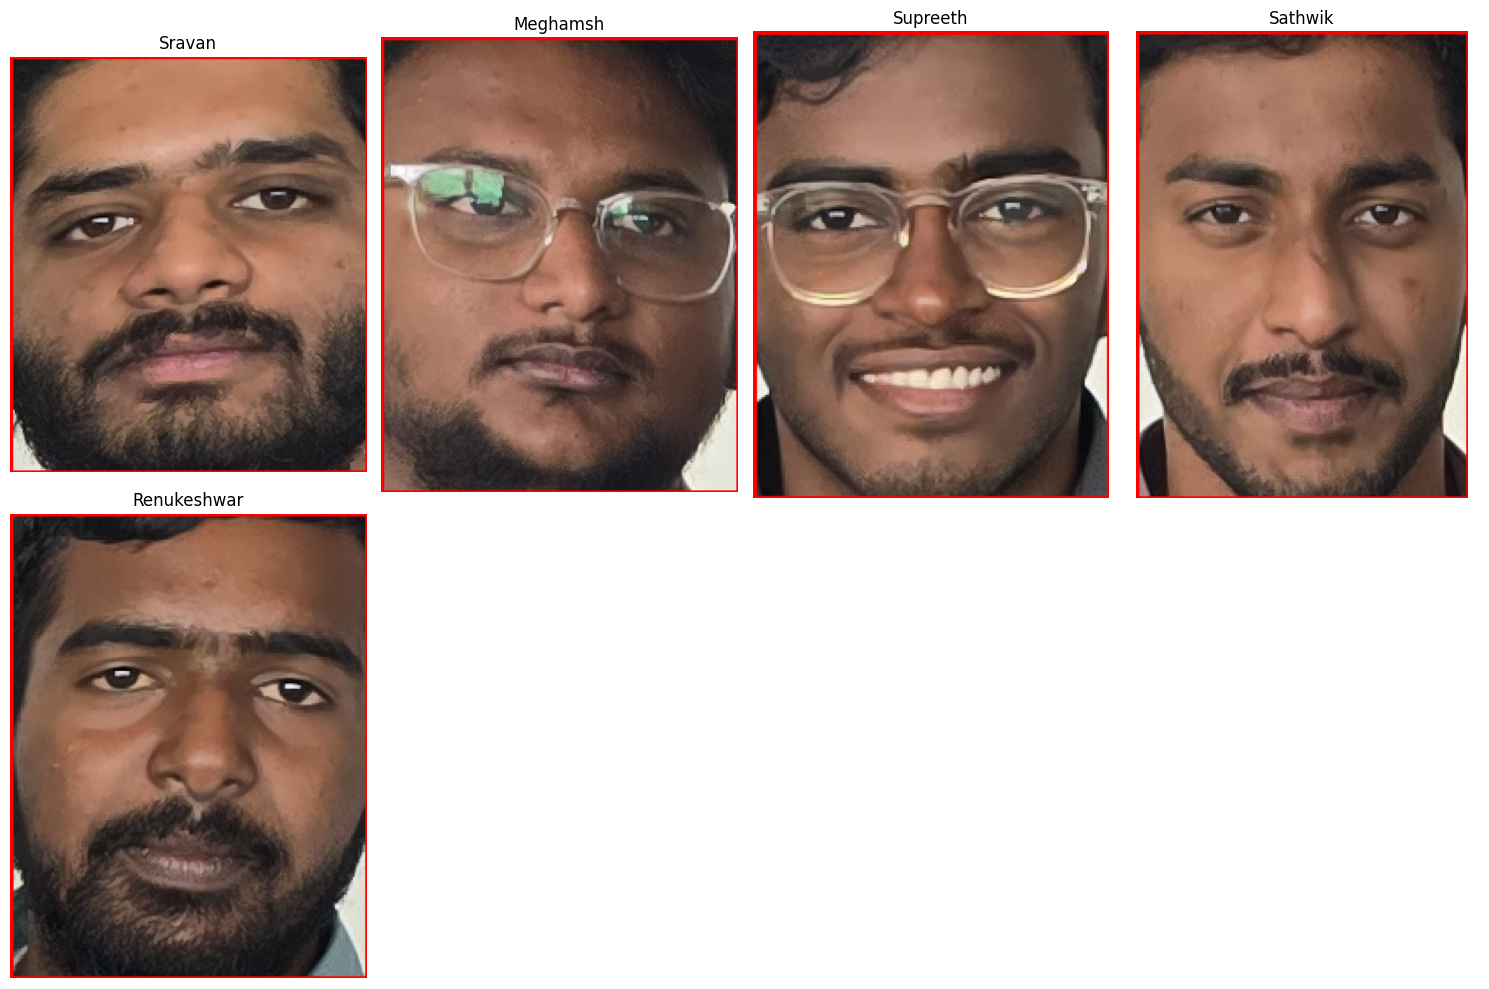

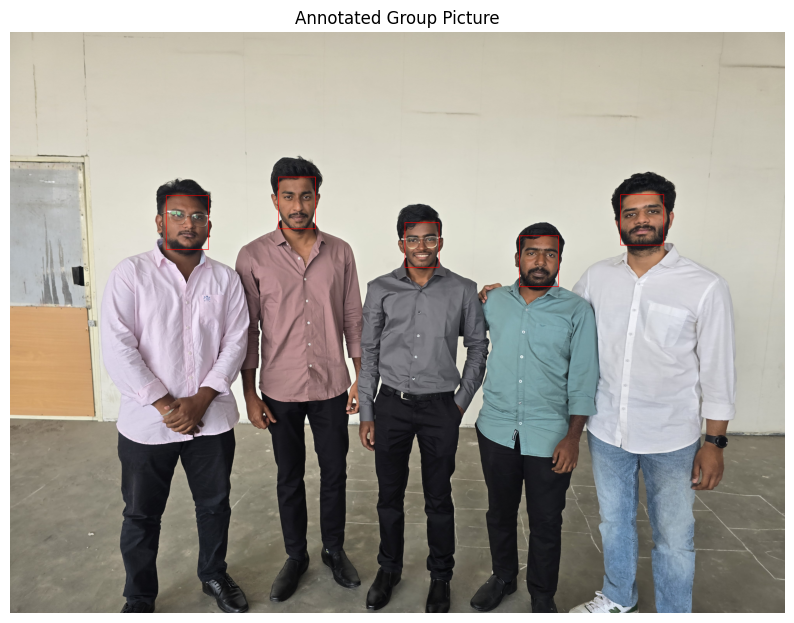

In [ ]:
# Path to the group picture
group_picture_path = "/content/drive/MyDrive/Capstone/Group Pics/New Group Pics/20250108_135242.jpg"

# Process the group picture
process_group_picture(group_picture_path, model, train_generator.class_indices)



In [ ]:
# Path to the group picture
group_picture_path = "/content/drive/MyDrive/Capstone/Group Pics/New Group Pics/20250108_135333.jpg"

# Process the group picture
process_group_picture(group_picture_path, model, train_generator.class_indices)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Path to the group picture
group_picture_path = "/content/drive/MyDrive/Capstone/Group Pics/New Group Pics/20250108_135331.jpg"

# Process the group picture
process_group_picture(group_picture_path, model, train_generator.class_indices)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Path to the group picture
group_picture_path = "/content/drive/MyDrive/Capstone/Group Pics/New Group Pics/20250108_135319.jpg"

# Process the group picture
process_group_picture(group_picture_path, model, train_generator.class_indices)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Path to the group picture
group_picture_path = "/content/drive/MyDrive/Capstone/Group Pics/New Group Pics/20250108_135330.jpg"

# Process the group picture
process_group_picture(group_picture_path, model, train_generator.class_indices)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Path to the group picture
group_picture_path = "/content/drive/MyDrive/Capstone/Group Pics/New Group Pics/20250108_135255.jpg"

# Process the group picture
process_group_picture(group_picture_path, model, train_generator.class_indices)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Path to the group picture
group_picture_path = "/content/drive/MyDrive/Capstone/Group Pics/New Group Pics/20250108_135311.jpg"

# Process the group picture
process_group_picture(group_picture_path, model, train_generator.class_indices)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Path to the group picture
group_picture_path = "/content/drive/MyDrive/Capstone/Group Pics/New Group Pics/IMG_20250108_150911825.jpg"

# Process the group picture
process_group_picture(group_picture_path, model, train_generator.class_indices)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import numpy as np
from mtcnn import MTCNN  # Install with `pip install mtcnn`
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt


# Step 1: Face Detection
# Step 1: Face Detection
def detect_faces(image_path, min_face_area=25000):
    """
    Detect faces in an image while filtering out small faces based on a minimum face area.
    """
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for MTCNN
    detector = MTCNN()  # Initialize the MTCNN detector

    # Detect faces
    detections = detector.detect_faces(image_rgb)

    # Filter out small faces based on the area
    filtered_detections = []
    for detection in detections:
        x, y, width, height = detection['box']
        face_area = width * height
        if face_area >= min_face_area:  # Include only if face area is above the threshold
            filtered_detections.append(detection)

    return image, image_rgb, filtered_detections

'''def detect_faces(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for MTCNN
    detector = MTCNN()  # Initialize the MTCNN detector

    # Detect faces
    detections = detector.detect_faces(image_rgb)

    return image, image_rgb, detections
'''

# Step 2: Crop, Recognize, and Annotate Faces
def crop_and_recognize_faces(image_rgb, detections, model, class_indices):
    """
    Crop faces, predict their identity using the model, and annotate the image with names or 'Unknown' along with confidence percentages.
    """
    class_labels = {v: k for k, v in class_indices.items()}
    faces_with_predictions = []  # Store cropped faces and predictions for display

    for i, detection in enumerate(detections):
        # Extract face bounding box with padding
        x, y, width, height = detection['box']
        x, y = abs(x), abs(y)  # Ensure coordinates are positive
        x2, y2 = x + width, y + height

        # Apply padding
        padding = 0 #0.2  # 20% padding around the face
        x_padding = int(width * padding)
        y_padding = int(height * padding)
        x = max(0, x - x_padding)
        y = max(0, y - y_padding)
        x2 = min(image_rgb.shape[1], x2 + x_padding)
        y2 = min(image_rgb.shape[0], y2 + y_padding)

        # Crop and preprocess the face
        face = image_rgb[y:y2, x:x2]
        face_resized = cv2.resize(face, (64, 64))  # Resize to model input size
        face_array = img_to_array(face_resized) / 255.0
        face_array = np.expand_dims(face_array, axis=0)

        # Predict the class
        prediction = model.predict(face_array)
        confidence = np.max(prediction)
        predicted_class_index = np.argmax(prediction, axis=1)[0]
        predicted_class_name = class_labels.get(predicted_class_index, "Unknown")

        # If confidence is low, classify as "Unknown"
        if confidence < 0.1:  # Adjust threshold as needed
            predicted_class_name = "Unknown"

        # Annotate the image with name and confidence
        label_text = f"{predicted_class_name} ({confidence * 100:.2f}%)"
        cv2.rectangle(image_rgb, (x, y), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image_rgb, label_text, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        # Store face and prediction for grid display
        faces_with_predictions.append((face, label_text))

    # Display cropped faces with predictions in a grid
    num_faces = len(faces_with_predictions)
    cols = min(num_faces, 4)  # Maximum of 4 faces per row
    rows = (num_faces + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()

    for ax, (face, label) in zip(axes, faces_with_predictions):
        ax.imshow(face)
        ax.set_title(label, fontsize=12)
        ax.axis("off")

    # Remove empty subplots
    for ax in axes[len(faces_with_predictions):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    return image_rgb


# Step 3: Process the Group Picture
# Process the group picture
def process_group_picture(image_path, model, class_indices, min_face_area=25000):
    # Detect faces
    image, image_rgb, detections = detect_faces(image_path, min_face_area)

    # If no faces detected, return
    if not detections:
        print("No faces detected!")
        return

    # Crop, recognize, and annotate
    annotated_image = crop_and_recognize_faces(image_rgb, detections, model, class_indices)

    # Display the annotated group picture
    plt.figure(figsize=(10, 10))
    plt.imshow(annotated_image)
    plt.axis("off")
    plt.title("Annotated Group Picture")
    plt.show()


In [ ]:
# Path to the group picture
group_picture_path = "/content/drive/MyDrive/Capstone/Group Pics/New Group Pics/IMG_20250108_150911825.jpg"

# Process the group picture
process_group_picture(group_picture_path, model, train_generator.class_indices)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Path to the group picture
group_picture_path = "/content/drive/MyDrive/Capstone/Group Pics/New Group Pics/IMG_20250108_150901824.jpg"

# Process the group picture
process_group_picture(group_picture_path, model, train_generator.class_indices)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Path to the group picture
group_picture_path = "/content/drive/MyDrive/Capstone/Group Pics/New Group Pics/IMG_20250108_150906267.jpg"

# Process the group picture
process_group_picture(group_picture_path, model, train_generator.class_indices)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Path to the group picture
group_picture_path = "/content/drive/MyDrive/Capstone/Group Pics/New Group Pics/IMG_20250108_150908010.jpg"

# Process the group picture
process_group_picture(group_picture_path, model, train_generator.class_indices)


Output hidden; open in https://colab.research.google.com to view.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


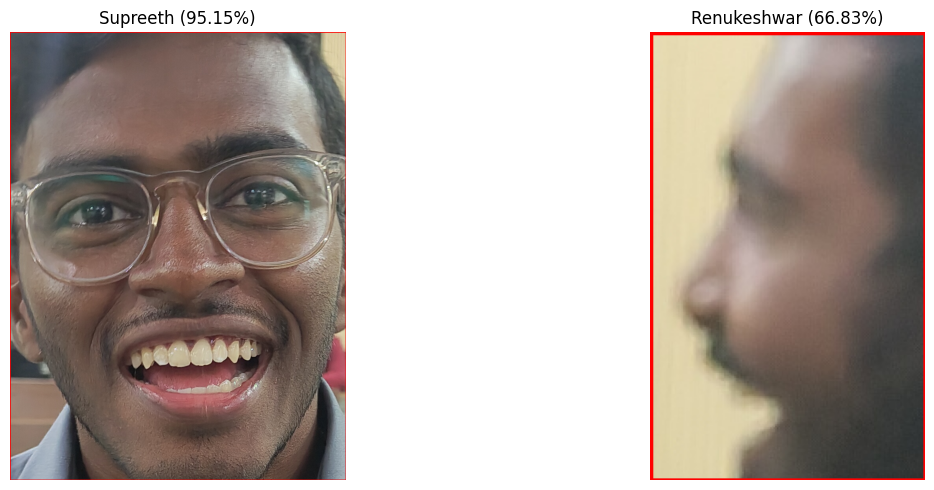

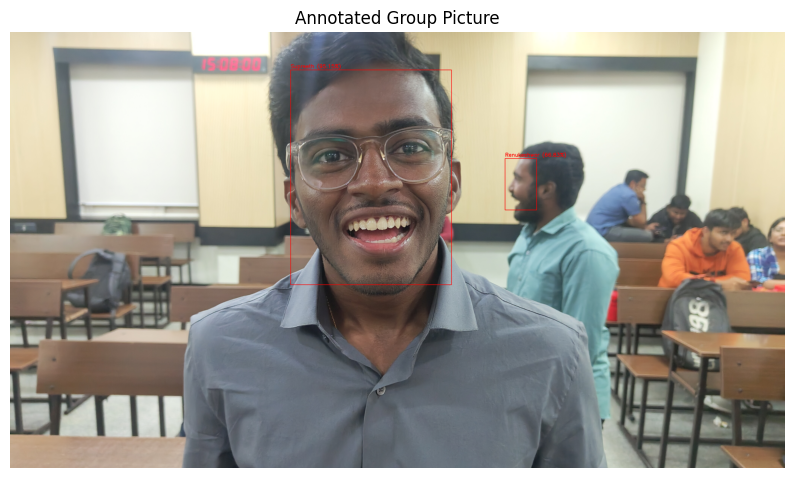

In [ ]:
# Path to the group picture
group_picture_path = "/content/drive/MyDrive/Capstone/Group Pics/New Group Pics/IMG_20250108_150800522.jpg"

# Process the group picture
process_group_picture(group_picture_path, model, train_generator.class_indices)


In [ ]:
# Path to the group picture
group_picture_path = "/content/drive/MyDrive/Capstone/Group Pics/New Group Pics/IMG_20250108_150917776.jpg"

# Process the group picture
process_group_picture(group_picture_path, model, train_generator.class_indices)


Output hidden; open in https://colab.research.google.com to view.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


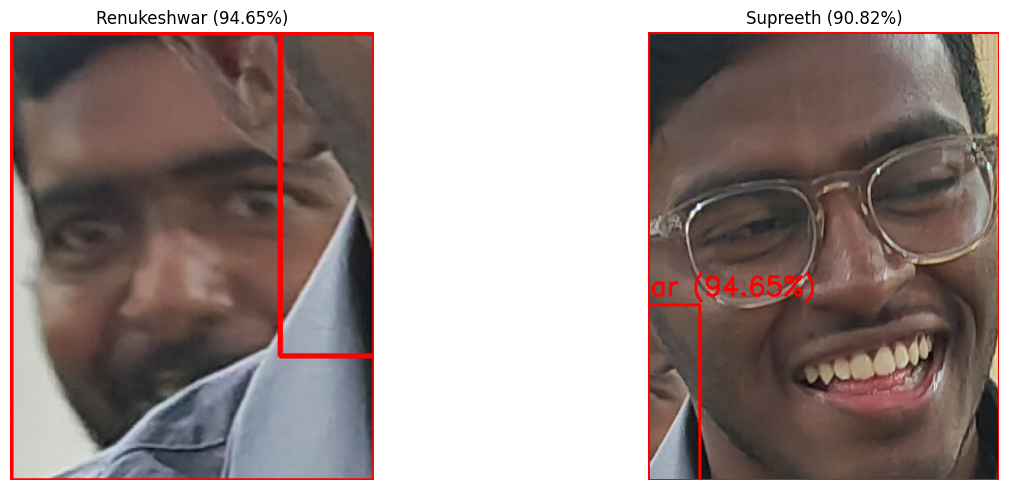

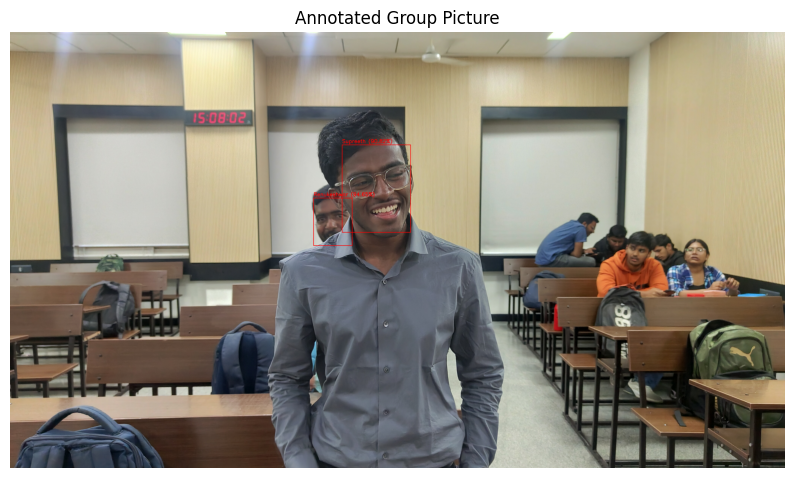

In [ ]:
# Path to the group picture
group_picture_path = "/content/drive/MyDrive/Capstone/Group Pics/New Group Pics/IMG_20250108_150804841.jpg"

# Process the group picture
process_group_picture(group_picture_path, model, train_generator.class_indices)
